In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

In [11]:
#date 
historical_path = "historical_data.csv"
sentiment_path = "fear_greed_index.csv"

df_trades = pd.read_csv(historical_path)
df_sentiment = pd.read_csv(sentiment_path)

print("Trades dataset shape:", df_trades.shape)
print("Sentiment dataset shape:", df_sentiment.shape)
df_trades.head()

Trades dataset shape: (211224, 16)
Sentiment dataset shape: (2644, 4)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [14]:
#Convert timestamps to datetime
if 'Timestamp IST' in df_trades.columns:
    df_trades['Timestamp IST'] = pd.to_datetime(
        df_trades['Timestamp IST'],
        dayfirst=True,       # For DD-MM-YYYY HH:MM format
        errors='coerce'      # Invalid timestamps become NaT
    )
    # Drop rows with invalid or missing timestamps
    df_trades = df_trades.dropna(subset=['Timestamp IST'])
    df_trades['date'] = df_trades['Timestamp IST'].dt.date
else:
    print(" 'Timestamp IST' column not found. Please check the CSV header names.")
    print("Available columns:", df_trades.columns.tolist())

#Convert sentiment date column
date_col = 'date' if 'date' in df_sentiment.columns else df_sentiment.columns[0]
df_sentiment[date_col] = pd.to_datetime(df_sentiment[date_col], dayfirst=True, errors='coerce').dt.date

print("Converted date columns successfully.\n")
print("Sentiment columns:", df_sentiment.columns.tolist())
print(df_sentiment.head())


Converted date columns successfully.

Sentiment columns: ['timestamp', 'value', 'classification', 'date']
    timestamp  value classification        date
0  1517463000     30           Fear  2018-01-02
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-03-02
3  1517722200     24   Extreme Fear  2018-04-02
4  1517808600     11   Extreme Fear  2018-05-02


In [15]:
#Merge datasets on date
df_merged = pd.merge(
    df_trades,
    df_sentiment,
    left_on='date',
    right_on=date_col,
    how='left'
)

print("Merged dataset shape:", df_merged.shape)
df_merged.head()

Merged dataset shape: (211224, 20)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,timestamp,value,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,1.707716e+09,70.0,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,1.707716e+09,70.0,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,1.707716e+09,70.0,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,1.707716e+09,70.0,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,1.707716e+09,70.0,Greed


In [16]:
pnl_col = None
for c in df_merged.columns:
    if 'pnl' in c.lower():
        pnl_col = c
        break

if pnl_col is None:
    raise ValueError("❌ Could not find a PnL column. Please check the CSV column names.")

df_merged['pnl'] = pd.to_numeric(df_merged[pnl_col], errors='coerce')
df_merged['is_win'] = (df_merged['pnl'] > 0).astype(int)
df_merged['abs_pnl'] = df_merged['pnl'].abs()

In [17]:
#Summary Statistics by Sentiment Classification
classification_col = None
for c in df_merged.columns:
    if 'class' in c.lower():
        classification_col = c
        break

if classification_col is None:
    raise ValueError("Could not find a sentiment classification column in the merged dataset.")

sent_summary = (
    df_merged.groupby(classification_col)
    .agg(trades_count=('pnl', 'count'),
         mean_pnl=('pnl', 'mean'),
         median_pnl=('pnl', 'median'),
         win_rate=('is_win', 'mean'),
         avg_abs_pnl=('abs_pnl', 'mean'))
    .reset_index()
    .sort_values('mean_pnl', ascending=False)
)

print("\n Summary by Sentiment Classification:")
display(sent_summary)



 Summary by Sentiment Classification:


,classification,trades_count,mean_pnl,median_pnl,win_rate,avg_abs_pnl
1,Extreme Greed,5621,205.816345,0.96048,0.553282,256.245873
2,Fear,13869,128.287950,0.00000,0.381787,156.936295
3,Greed,11292,53.988003,0.00000,0.435707,118.729954
4,Neutral,2756,27.088803,0.00000,0.494920,34.048262
0,Extreme Fear,2326,1.891632,0.00000,0.292777,9.988225


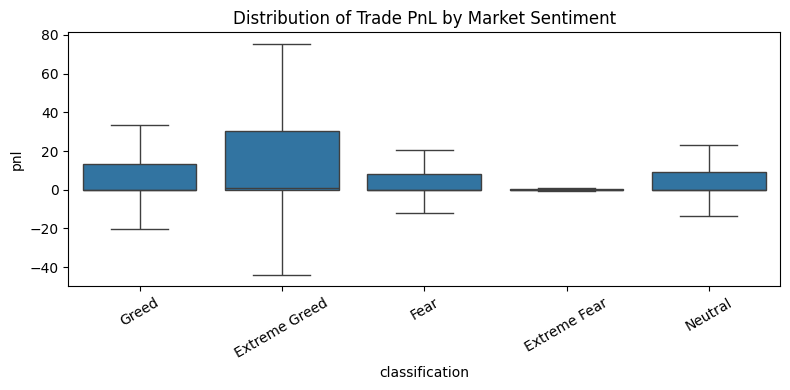

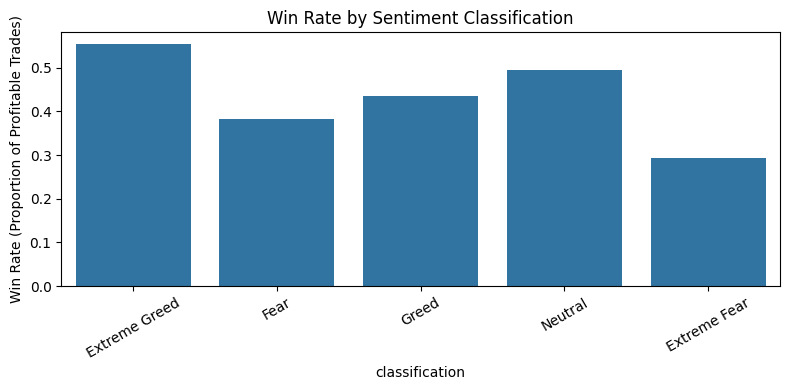

In [22]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df_merged, x=classification_col, y='pnl', showfliers=False)
plt.title("Distribution of Trade PnL by Market Sentiment")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(data=sent_summary, x=classification_col, y='win_rate')
plt.title("Win Rate by Sentiment Classification")
plt.ylabel("Win Rate (Proportion of Profitable Trades)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

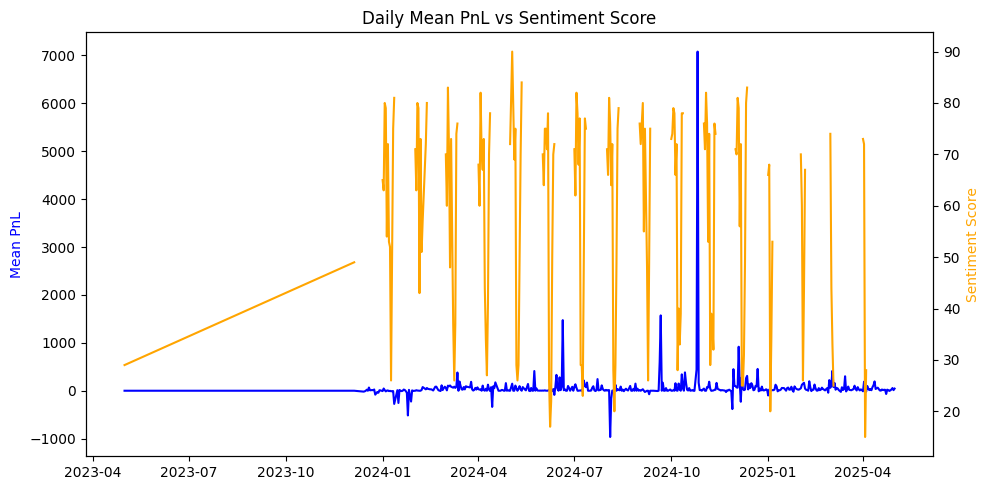

In [25]:
#Daily Average 
if 'value' in df_merged.columns:
    daily_perf = df_merged.groupby('date').agg(
        mean_pnl=('pnl', 'mean'),
        sentiment_score=('value', 'mean')
    ).reset_index()

    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.plot(daily_perf['date'], daily_perf['mean_pnl'], label='Mean PnL', color='blue')
    ax1.set_ylabel('Mean PnL', color='blue')
    ax2 = ax1.twinx()
    ax2.plot(daily_perf['date'], daily_perf['sentiment_score'], label='Sentiment Score', color='orange')
    ax2.set_ylabel('Sentiment Score', color='orange')
    plt.title("Daily Mean PnL vs Sentiment Score")
    plt.tight_layout()
    plt.show()


In [26]:
fear_mask = df_merged[classification_col].astype(str).str.lower().str.contains("fear", na=False)
greed_mask = df_merged[classification_col].astype(str).str.lower().str.contains("greed", na=False)

fear_pnl = df_merged.loc[fear_mask, 'pnl'].dropna()
greed_pnl = df_merged.loc[greed_mask, 'pnl'].dropna()

if len(fear_pnl) > 0 and len(greed_pnl) > 0:
    stat, pval = mannwhitneyu(fear_pnl, greed_pnl, alternative='two-sided')
    print(f"\n Mann–Whitney U Test: Fear vs Greed PnL Distributions")
    print(f"U-statistic = {stat:.2f}, p-value = {pval:.4f}")
else:
    print("Not enough data for Fear or Greed classes to run the test.")


 Mann–Whitney U Test: Fear vs Greed PnL Distributions
U-statistic = 122776380.00, p-value = 0.0000
